In [101]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
import random
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import IsolationForest
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as PLT
from tensorflow.keras.callbacks import ModelCheckpoint

In [49]:
n = 5000
skip = sorted(random.sample(range(1,319795),319795-n))
DF = pd.read_csv('../../datasets/heart_2020_cleaned.csv',skiprows=skip).reset_index().rename(columns={'index':'id'})

In [50]:
# DF = pd.read_csv('../../datasets/heart_2020_cleaned.csv').reset_index().rename(columns={'index':'id'})
CatCols = [
    'Smoking','AlcoholDrinking','Stroke','DiffWalking','Sex','AgeCategory','Race','Diabetic',
    'PhysicalActivity','GenHealth','Asthma','KidneyDisease','SkinCancer'
]
NumCols = [
    'BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime'
]

X = DF[DF.columns.difference(['id','HeartDisease'])]
Y = DF['HeartDisease']

In [51]:
X.head()

,AgeCategory,AlcoholDrinking,Asthma,BMI,Diabetic,DiffWalking,GenHealth,KidneyDisease,MentalHealth,PhysicalActivity,PhysicalHealth,Race,Sex,SkinCancer,SleepTime,Smoking,Stroke
0,60-64,No,No,25.06,Yes,No,Very good,No,0.0,Yes,2.0,White,Female,Yes,8.0,No,No
1,35-39,No,No,34.34,No,No,Very good,No,0.0,No,5.0,Black,Female,No,7.0,No,No
2,60-64,No,No,36.02,Yes,Yes,Fair,No,15.0,No,30.0,Black,Female,No,7.0,No,No
3,60-64,No,No,37.24,No,No,Good,No,0.0,Yes,0.0,Black,Female,No,10.0,No,No
4,65-69,No,No,26.07,No,No,Poor,No,0.0,Yes,30.0,White,Female,No,7.0,No,No


In [52]:
def columns_OHC_transforme(DF,columns):
    merged = pd.DataFrame()
    for column_name in columns:
        label_encoder = LabelEncoder()
        encoded = label_encoder.fit_transform(DF[column_name])
        labels =pd.Series(label_encoder.classes_)

        clmt = ColumnTransformer([(column_name,OneHotEncoder(),[0])], remainder='passthrough')
        clmt_fited_data = clmt.fit_transform(DF[[column_name]]) 
        clmt_fited_data = clmt_fited_data if type(clmt_fited_data)== np.ndarray else clmt_fited_data.toarray()
        NDF = pd.DataFrame(clmt_fited_data,columns=[f'{column_name}_{x}' for x in labels]).set_index(DF.index)
        merged = pd.concat([merged,NDF],axis=1)
    DF = DF.drop(columns=columns)
    DF = DF.merge(merged, left_index=True,right_index=True)

    return DF

In [53]:
X = columns_OHC_transforme(X,CatCols) 
Y_label_encoder = LabelEncoder()
Y = DF.iloc[X.index]['HeartDisease']
Y = Y_label_encoder.fit_transform(Y)

In [54]:
ss = StandardScaler()
X[NumCols] = ss.fit_transform(X[NumCols])

In [55]:
isoforest = IsolationForest(n_estimators=3000,max_features=50)
X['is_noise'] = isoforest.fit_predict(X)
X = X[X['is_noise'] == 1]
Y = Y[X.index]
X = X[X.columns.difference(['is_noise'])]

## imbalance data

In [56]:
weights = compute_class_weight(class_weight='balanced',classes=np.unique(Y), y=Y)
class_weights = dict( zip(np.unique(Y), weights) )
class_weights

{0: 0.5318715552360412, 1: 8.343984962406015}

In [9]:
# toml =RandomOverSampler(random_state=3020)
# X, Y = toml.fit_resample(X,pd.DataFrame(Y,columns=['HeartDisease']))
# DF = pd.concat([X,pd.DataFrame(Y,columns=['HeartDisease'])],axis=1)

In [61]:
Y = pd.get_dummies(Y)

In [62]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,random_state=3020,train_size=.90)

In [102]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50,activation='relu',input_shape=(50,)),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(100,activation='relu'),
#     tf.keras.layers.Dense(100,activation='relu'),
#     tf.keras.layers.Dense(200,activation='relu'),
    tf.keras.layers.Dense(2,activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Nadam(0.01),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [103]:
es = EarlyStopping(monitor='val_loss',mode='min',patience=20)
rlrop = ReduceLROnPlateau(monitor='val_loss',patience=10, factor=.002, min_lr=.01)
mchp = ModelCheckpoint('heart.h5',monitor='val_loss',mode='min',save_best_only=True)

In [104]:
history = model.fit(X_train, Y_train, 
                    epochs=100,
                    validation_data=(X_test,Y_test),
                    batch_size=200,
                    class_weight=class_weights,
                    callbacks=[mchp] #es,rlrop,
                   )

Epoch 1/100


/opt/conda/lib/python3.9/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/20 [===========================>..] - ETA: 0s - loss: 0.6451 - categorical_accuracy: 0.6834

/opt/conda/lib/python3.9/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


20/20 [==============================] - 2s 41ms/step - loss: 0.6368 - categorical_accuracy: 0.6811 - val_loss: 0.3915 - val_categorical_accuracy: 0.8131
Epoch 2/100
20/20 [==============================] - 1s 25ms/step - loss: 0.5258 - categorical_accuracy: 0.6874 - val_loss: 0.5249 - val_categorical_accuracy: 0.7027
Epoch 3/100
20/20 [==============================] - 1s 27ms/step - loss: 0.4830 - categorical_accuracy: 0.6899 - val_loss: 0.3462 - val_categorical_accuracy: 0.8288
Epoch 4/100
20/20 [==============================] - 0s 22ms/step - loss: 0.4662 - categorical_accuracy: 0.7342 - val_loss: 0.4840 - val_categorical_accuracy: 0.7230
Epoch 5/100
20/20 [==============================] - 1s 28ms/step - loss: 0.4546 - categorical_accuracy: 0.7252 - val_loss: 0.5289 - val_categorical_accuracy: 0.6734
Epoch 6/100
20/20 [==============================] - 1s 26ms/step - loss: 0.4472 - categorical_accuracy: 0.7322 - val_loss: 0.4778 - val_categorical_accuracy: 0.6959
Epoch 7/100
20/2

20/20 [==============================] - 0s 12ms/step - loss: 0.0763 - categorical_accuracy: 0.9544 - val_loss: 1.1314 - val_categorical_accuracy: 0.8806
Epoch 51/100
20/20 [==============================] - 0s 21ms/step - loss: 0.0787 - categorical_accuracy: 0.9587 - val_loss: 1.1382 - val_categorical_accuracy: 0.8851
Epoch 52/100
20/20 [==============================] - 0s 22ms/step - loss: 0.0658 - categorical_accuracy: 0.9612 - val_loss: 1.1846 - val_categorical_accuracy: 0.8874
Epoch 53/100
20/20 [==============================] - 0s 22ms/step - loss: 0.0646 - categorical_accuracy: 0.9680 - val_loss: 1.2866 - val_categorical_accuracy: 0.9009
Epoch 54/100
20/20 [==============================] - 0s 17ms/step - loss: 0.0787 - categorical_accuracy: 0.9620 - val_loss: 1.2743 - val_categorical_accuracy: 0.8986
Epoch 55/100
20/20 [==============================] - 0s 21ms/step - loss: 0.0924 - categorical_accuracy: 0.9667 - val_loss: 1.6155 - val_categorical_accuracy: 0.7320
Epoch 56/10

20/20 [==============================] - 0s 23ms/step - loss: 0.0313 - categorical_accuracy: 0.9835 - val_loss: 1.4293 - val_categorical_accuracy: 0.9054
Epoch 100/100
20/20 [==============================] - 0s 23ms/step - loss: 0.0268 - categorical_accuracy: 0.9862 - val_loss: 1.4497 - val_categorical_accuracy: 0.9032


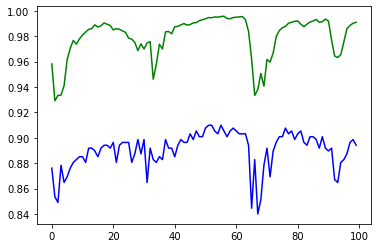

In [100]:
PLT.plot(history.history['categorical_accuracy'],color='green')
PLT.plot(history.history['val_categorical_accuracy'],color='blue')

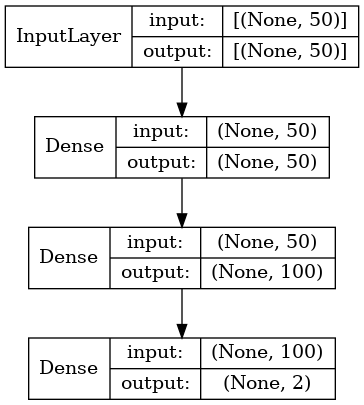

In [65]:
plot_model(model, show_shapes=True,show_layer_names=False)

In [16]:
model.predict(X_test)[0]

26/26 [==============================] - 0s 5ms/step


array([5.051873e-04, 9.994948e-01], dtype=float32)

In [17]:
np.argmax(model.predict(X_test)[0])

26/26 [==============================] - 0s 7ms/step


1